In [1]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
print("total number of words : ", len(words))

total number of words :  32033


In [3]:
# build the vocablury
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print("vocab size : ", vocab_size)


vocab size :  27


In [4]:
# build the dataset

block_size = 3

def build_dataset(words):
    x, y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])


In [5]:
# MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn((vocab_size), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("total number of parameters : ", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


total number of parameters :  12297


In [6]:
# same optimization step as last time

max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, xtr.shape[0], (batch_size, ), generator=g)
    xb, yb = xtr[ix], ytr[ix]

    # forward pass
    emb = C[xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    bnmeani = hpreact.mean(0, keepdim =True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # update the weights
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps:7d} : {loss.item():.4f}")
    losses.append(loss.item())





      0 /  200000 : 3.7900
  10000 /  200000 : 2.1710
  20000 /  200000 : 2.3751
  30000 /  200000 : 2.4285
  40000 /  200000 : 1.9732
  50000 /  200000 : 2.3582
  60000 /  200000 : 2.4149
  70000 /  200000 : 2.0888
  80000 /  200000 : 2.3643
  90000 /  200000 : 2.1519
 100000 /  200000 : 1.9356
 110000 /  200000 : 2.2957
 120000 /  200000 : 2.0134
 130000 /  200000 : 2.4722
 140000 /  200000 : 2.3633
 150000 /  200000 : 2.1834
 160000 /  200000 : 2.0060
 170000 /  200000 : 1.7924
 180000 /  200000 : 2.0408
 190000 /  200000 : 1.9124


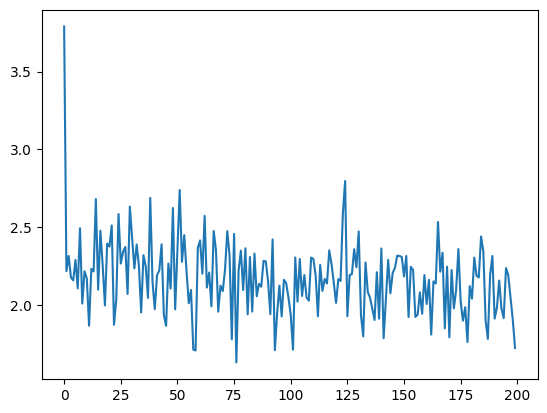

In [7]:
import math
plt.plot([l for i, l in enumerate(losses) if i % 1000 == 0])

In [12]:
@torch.no_grad()

def split_loss(split):
    x, y = {
        "train" : (xtr, ytr),
        "val" : (xdev, ydev),
        "test" : (xte, yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #  + b1
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.062927484512329
val 2.105050563812256


(array([494., 204., 165., 168., 128., 101., 136., 137.,  90., 114.,  86.,
         71.,  90., 109.,  97.,  88.,  94.,  87.,  89.,  80., 127.,  98.,
        153., 101., 112., 110.,  97.,  99.,  99.,  92., 111., 110.,  95.,
         84.,  89., 101.,  95.,  69., 102.,  88.,  95., 104., 131., 112.,
        121., 139., 151., 171., 264., 452.]),
 array([-9.99995291e-01, -9.59996529e-01, -9.19997766e-01, -8.79999003e-01,
        -8.40000241e-01, -8.00001478e-01, -7.60002716e-01, -7.20003953e-01,
        -6.80005190e-01, -6.40006428e-01, -6.00007665e-01, -5.60008903e-01,
        -5.20010140e-01, -4.80011377e-01, -4.40012615e-01, -4.00013852e-01,
        -3.60015090e-01, -3.20016327e-01, -2.80017564e-01, -2.40018802e-01,
        -2.00020039e-01, -1.60021276e-01, -1.20022514e-01, -8.00237513e-02,
        -4.00249887e-02, -2.62260437e-05,  3.99725366e-02,  7.99712992e-02,
         1.19970062e-01,  1.59968824e-01,  1.99967587e-01,  2.39966350e-01,
         2.79965112e-01,  3.19963875e-01,  3.59962

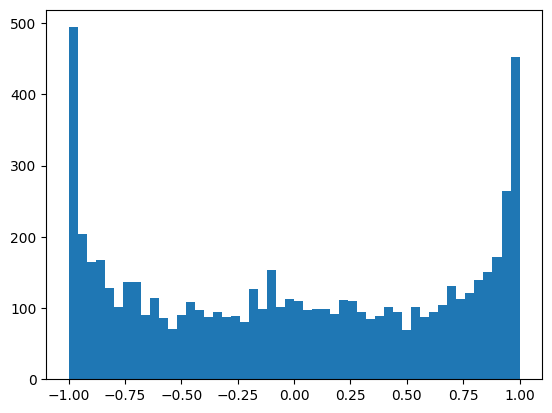

In [9]:
plt.hist(h.view(-1).tolist(), 50)

(array([  3.,   1.,   0.,   2.,   1.,   3.,   3.,   8.,   3.,   6.,  12.,
         12.,  18.,  39.,  39.,  53.,  78.,  92.,  91., 113., 136., 196.,
        255., 303., 365., 409., 532., 648., 560., 448., 364., 326., 268.,
        219., 178., 167., 121.,  85.,  69.,  53.,  47.,  21.,  15.,  10.,
         10.,   6.,   2.,   4.,   3.,   3.]),
 array([-6.48127317, -6.24701667, -6.01276016, -5.77850366, -5.54424715,
        -5.30999064, -5.07573414, -4.84147763, -4.60722113, -4.37296462,
        -4.13870811, -3.90445161, -3.6701951 , -3.4359386 , -3.20168209,
        -2.96742558, -2.73316908, -2.49891257, -2.26465607, -2.03039956,
        -1.79614305, -1.56188655, -1.32763004, -1.09337354, -0.85911703,
        -0.62486053, -0.39060402, -0.15634751,  0.07790899,  0.3121655 ,
         0.546422  ,  0.78067851,  1.01493502,  1.24919152,  1.48344803,
         1.71770453,  1.95196104,  2.18621755,  2.42047405,  2.65473056,
         2.88898706,  3.12324357,  3.35750008,  3.59175658,  3.82601309,
 

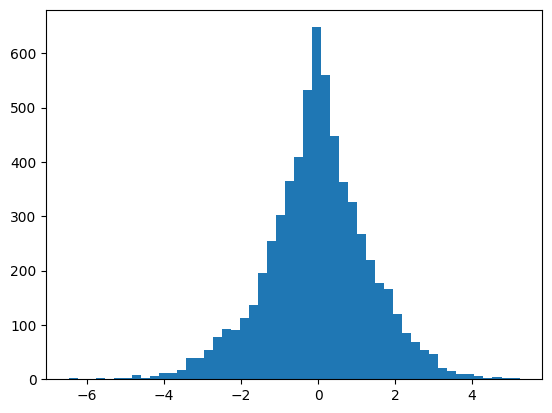

In [10]:
plt.hist(hpreact.view(-1).tolist(), 50)

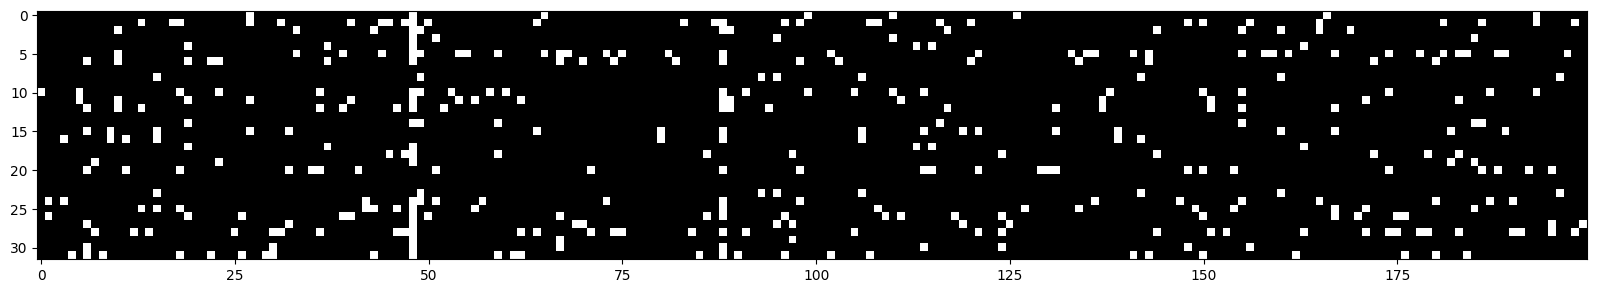

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation = "nearest")

In [219]:
# pytorchifying our code

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight

        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.dim = dim
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = xhat * self.gamma + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].gamma *= 0.1

    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3/3
    # layers[0].weight *= 3
    
    parameters = [C] + [p for layer in layers for p in layer.parameters()]

    print("total params : ", sum(p.nelement() for p in parameters))

    for p in parameters:
        p.requires_grad = True


total params :  47551


In [220]:
# same optimization step

max_steps = 200000
batch_size = 32
losses = []
ud = []

for i in range(max_steps):

    # minibatch calculation
    ix = torch.randint(0, vocab_size, (batch_size, ), generator=g)
    xb, yb = xtr[ix], ytr[ix]

    # forward pass
    emb = C[xb[ix]]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, yb)

    # backward pass
    for layer in layers:            # AFTER DEBUG remove it
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()


    # update the loss
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
            
    losses.append(loss.item())
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break                       # AFTER DEBUG remove it

      0/ 200000 : 3.2767
   1000/ 200000 : 2.5275


layer 2 {      Tanh} : mean : -0.00, std : 0.64, saturated : 2.81%
layer 5 {      Tanh} : mean : -0.01, std : 0.65, saturated : 1.81%
layer 8 {      Tanh} : mean : +0.00, std : 0.65, saturated : 1.91%
layer 11 {      Tanh} : mean : -0.00, std : 0.65, saturated : 1.81%
layer 14 {      Tanh} : mean : +0.00, std : 0.65, saturated : 1.88%


Text(0.5, 1.0, 'activation distribution')

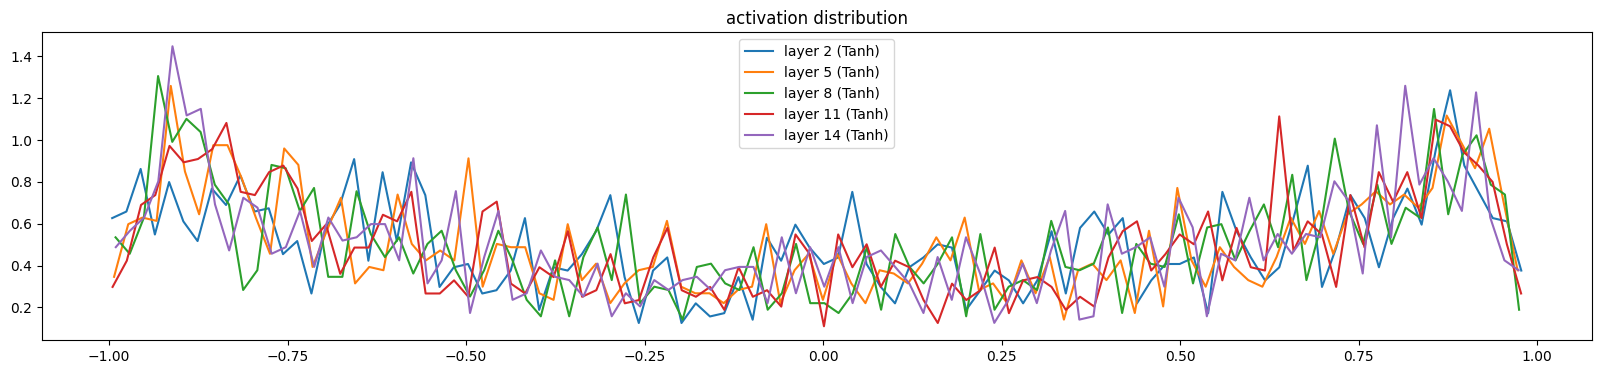

In [221]:
# visuzlize the histograms

plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d {%10s} : mean : %+.2f, std : %.2f, saturated : %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 {      Tanh} : mean : +0.00, std : 0.00, saturated : 0.00%
layer 5 {      Tanh} : mean : -0.00, std : 0.00, saturated : 0.00%
layer 8 {      Tanh} : mean : -0.00, std : 0.00, saturated : 0.00%
layer 11 {      Tanh} : mean : +0.00, std : 0.00, saturated : 0.00%
layer 14 {      Tanh} : mean : +0.00, std : 0.00, saturated : 0.00%


Text(0.5, 1.0, 'gradient distribution')

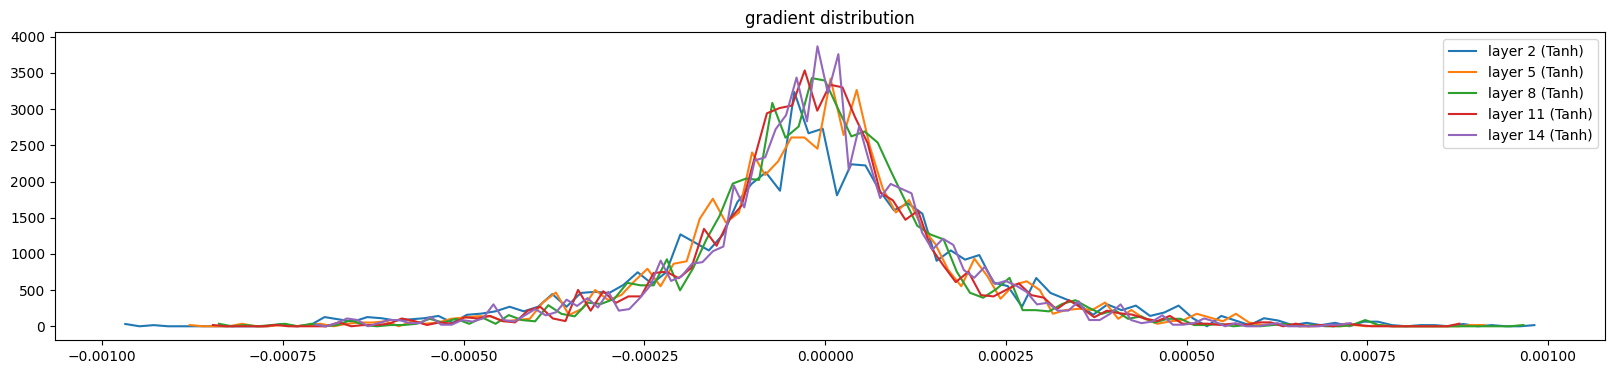

In [222]:
# visuzlize the histograms

plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d {%10s} : mean : %+.2f, std : %.2f, saturated : %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight {  (27, 10)} | mean : -0.00 | std : 0.00 | grad:data ratio 6.805211e-04
weight { (30, 100)} | mean : +0.00 | std : 0.00 | grad:data ratio 5.943447e-03
weight {(100, 100)} | mean : +0.00 | std : 0.00 | grad:data ratio 8.833211e-03
weight {(100, 100)} | mean : -0.00 | std : 0.00 | grad:data ratio 7.856287e-03
weight {(100, 100)} | mean : -0.00 | std : 0.00 | grad:data ratio 7.490656e-03
weight {(100, 100)} | mean : -0.00 | std : 0.00 | grad:data ratio 7.699586e-03
weight { (100, 27)} | mean : -0.00 | std : 0.00 | grad:data ratio 1.452775e-02


Text(0.5, 1.0, 'weights gradient distribution')

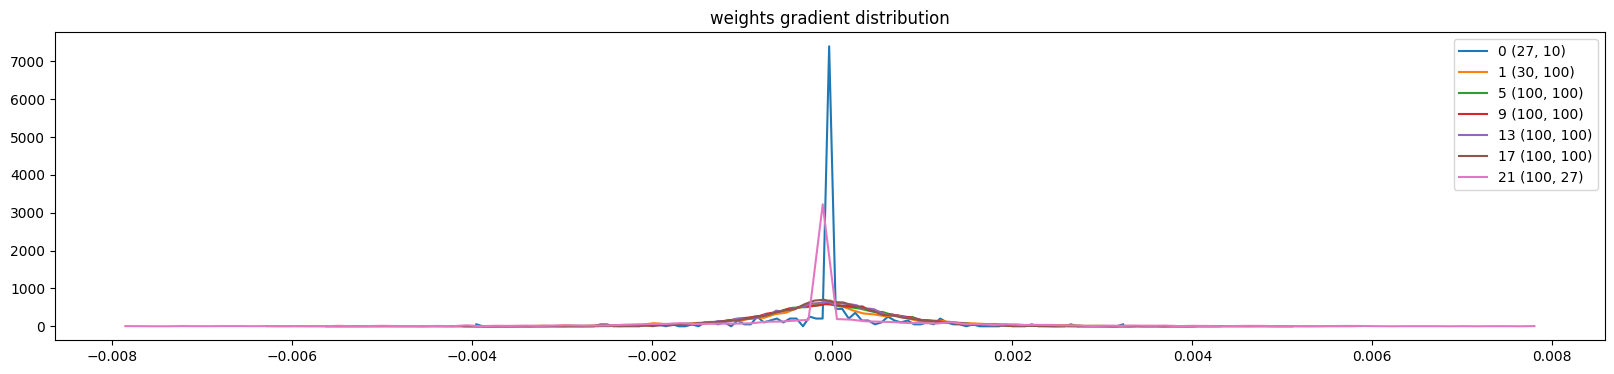

In [223]:
# visualize histograms

plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print("weight {%10s} | mean : %+.2f | std : %.2f | grad:data ratio %e" % ((tuple(p.shape)), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

Text(0.5, 1.0, 'Update values distribution')

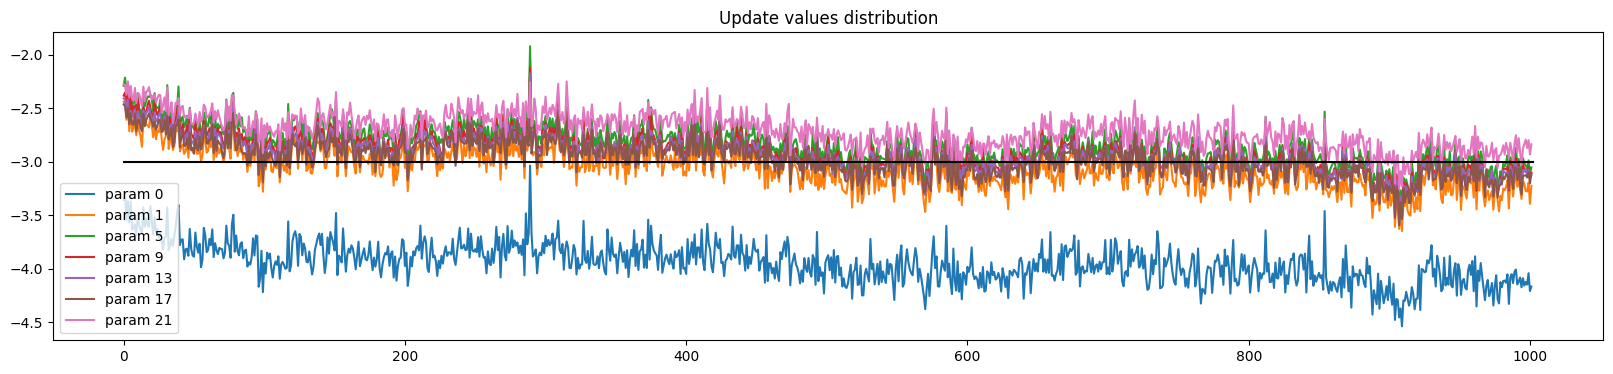

In [225]:
plt.figure(figsize=(20, 4))

legends = []

for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)

plt.plot([0, len(ud)], [-3, -3], "k") # these ratios should be ~1e-3, indiacte on the plot
plt.legend(legends)
plt.title("Update values distribution")